Packages

In [1]:
import pandas as pd
import numpy as np

import functools
from typing import Any, Tuple

import scipy.signal as scipy_signal

from matplotlib import colorbar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import folium
import plotly.express as px

In [3]:
#pip install finufft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import finufft

Data import and cleaning

In [4]:
df_NO2 = pd.read_csv("observation_set.csv")

In [5]:
df_NO2.head(6)

,OBJECTID,datetime,run_index,Longitude,Latitude,Elevation,hour,CO2,CO,NO,...,period,season,type,date,time,year,day,tot_hour_numeric,tot_min_numeric,tot_min_rounded
0,16091,2017-02-17 12:31:29,173565,-79.977161,40.430140,225.968182,12,517.372273,0.422173,17.615000,...,2,3,4,2017-02-17,12:31:29,2017,17,4634.608056,278076.483333,278076.0
1,10634,2017-02-02 09:50:38,122180,-79.997926,40.441055,274.931818,9,499.572350,0.137255,8.555914,...,1,3,4,2017-02-02,09:50:38,2017,2,4271.927222,256315.633333,256316.0
2,2485,2016-09-20 20:57:59,35619,-79.907425,40.490618,NaN,20,469.582763,0.552017,1.452951,...,3,1,3,2016-09-20,20:57:59,2016,20,1043.049722,62582.983333,62583.0
3,14692,2017-02-15 06:21:22,165359,-80.005746,40.438416,236.300000,6,520.905352,0.232678,3.899478,...,1,3,4,2017-02-15,06:21:22,2017,15,4580.439444,274826.366667,274826.0
4,8847,2017-01-31 12:04:59,115153,-79.956671,40.459469,295.581818,12,477.227354,0.121132,30.380059,...,2,3,3,2017-01-31,12:04:59,2017,31,4226.166389,253569.983333,253570.0
5,4193,2016-11-18 15:24:01,60,-80.079202,40.408026,255.568182,15,455.181827,0.441932,7.983373,...,2,2,3,2016-11-18,15:24:01,2016,18,2453.483611,147209.016667,147209.0


Average observations that fall into the same minute category so that we have one row per observed minute (for the short-time Fourier transform)

In [6]:
min_avg_NO2 = df_NO2.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()
min_avg_NO2.head()
#min_avg_NO2['tot_min_rounded'].max()

,tot_min_rounded,datetime,NO2
0,1.0,2016-08-08 09:56:02,13.752167
1,2.0,2016-08-08 09:56:59,14.866519
2,4.0,2016-08-08 09:59:00,11.266365
3,5.0,2016-08-08 10:00:01,11.102795
4,6.0,2016-08-08 10:01:00,10.909147


Examine the spacing of the sampling

In [7]:
# Sort the DataFrame based on the column with integers
sorted_df = min_avg_NO2.sort_values(by='tot_min_rounded')

# Get the differences between consecutive values
diff = sorted_df['tot_min_rounded'].diff()

# Find where the differences are greater than 2 indicating a larger gap
gaps = diff[diff > 2]

# Compute the number of missing integers in each gap
missing_counts = gaps - 1

# Displaying the number of missing integers in each gap
print(missing_counts)

33         3.0
45      1002.0
55        55.0
59         6.0
60         2.0
         ...  
4493      50.0
4519      23.0
4613     492.0
4696    2204.0
4940     678.0
Name: tot_min_rounded, Length: 207, dtype: float64


# Info on Non-uniform discrete Fourier Transform

The nonuniform discrete Fourier transform of type II (NUDFT-II) uses uniform (i.e. integer) frequencies but nonuniform sample points p_{n}. This corresponds to evaluating a Fourier series at nonequispaced points. It is also known as adjoint NDFT. In the FINUFFT package implementation this is called the "type 1" NUFFT.

## Example code from finufft documentation

In [9]:
# number of nonuniform points
M = 100

# the nonuniform points
x = 2 * np.pi * np.random.uniform(size=M)

# their complex strengths
c = (np.random.standard_normal(size=M)
    + 1J * np.random.standard_normal(size=M))

## Code for one day of data

In [10]:
# Convert column named 'datetime' to actual datetime
min_avg_NO2['datetime'] = pd.to_datetime(min_avg_NO2['datetime'])

# add day of year 
min_avg_NO2['day_of_year'] = min_avg_NO2['datetime'].dt.dayofyear

#see which days are included
min_avg_NO2.groupby('day_of_year').count()

day33 = min_avg_NO2[min_avg_NO2['day_of_year'] == 33]
day33.head()

,tot_min_rounded,datetime,NO2,day_of_year
3333,256063.0,2017-02-02 05:38:05,7.844182,33
3334,256064.0,2017-02-02 05:39:09,7.791027,33
3335,256065.0,2017-02-02 05:40:13,7.606351,33
3336,256066.0,2017-02-02 05:40:34,7.524876,33
3337,256067.0,2017-02-02 05:41:38,7.555510,33


In [11]:
#see example code at https://finufft.readthedocs.io/en/latest/python.html
c = day33['NO2'] #set the signal "strengths" to the observed outcome
c_complex = np.array([complex(num, 0) for num in c])



#need to normalize x to fall within [-3 pi , 3pi]
x = day33['tot_min_rounded'] #location of observations
x_norm = 2 * np.pi * (x - np.min(x))/(np.max(x) - np.min(x))

N = len(day33['NO2']//2) #number of desired Fourier modes

print(x_norm)

3333    0.000000
3334    0.019821
3335    0.039642
3336    0.059462
3337    0.079283
          ...   
3643    6.203902
3644    6.223723
3645    6.243544
3646    6.263365
3647    6.283185
Name: tot_min_rounded, Length: 315, dtype: float64


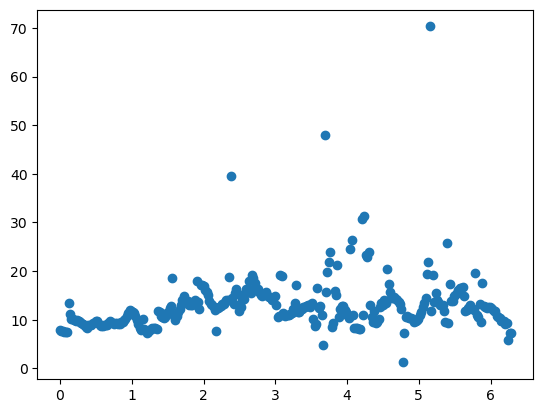

In [12]:
plt.scatter(x = x_norm, y = c)

In [13]:
x_norm = np.ascontiguousarray(x_norm)
c_complex = np.ascontiguousarray(c_complex)

# calculate the type-1 NUFFT
f = finufft.nufft1d1(x_norm, c_complex, N)




Find coefficients

In [14]:
#data is indexed by -N1/2 <= k1 <= (N1-1)/2 
#a_n = 2*f.real
#b_n = -2*f.imag


k_neg = np.flip(f[0: len(f)//2])
k_pos = f[len(f)//2 + 1:]
print(len(f),len(k_neg), len(k_pos))

C_n = np.abs(k_neg)**2 + np.abs(k_pos)**2
print(C_n)



315 157 157
[3.43368441e+05 1.78547682e+05 1.12327630e+04 6.69071452e+04
 3.34110695e+04 4.50243238e+03 4.34290624e+04 1.84217705e+04
 6.41709805e+04 7.24696616e+03 1.02575084e+03 2.99903586e+04
 4.74285147e+04 1.55779786e+05 1.84767089e+04 8.70204088e+03
 1.68803393e+02 3.82140569e+04 7.54872854e+03 6.08383247e+04
 4.27306235e+04 6.67456600e+04 5.76085182e+04 3.70990338e+03
 1.46611855e+03 1.26675317e+04 2.84101045e+04 3.64006560e+04
 3.12114642e+04 4.14935334e+04 7.96466774e+03 3.97679279e+03
 2.88661099e+04 3.86235358e+04 1.70783217e+04 3.81708878e+03
 1.76333921e+04 1.08229719e+04 1.49406880e+04 2.67305433e+04
 1.95040797e+04 6.30687640e+03 1.45846124e+04 2.11638610e+04
 2.09108031e+04 3.52882005e+03 1.99537327e+03 1.97107716e+04
 1.07664507e+04 3.99354463e+03 1.22565753e+04 3.98401468e+04
 2.92789547e+03 3.27384894e+03 1.26075784e+03 3.03246029e+04
 1.31681780e+04 1.57077643e+04 7.69960638e+03 3.95167653e+03
 2.08310535e+04 1.95629556e+03 1.95717829e+04 2.00644398e+04
 1.21973170e

Plot An and Bn

In [119]:
len(f)//2
157 + 1 + 157

315

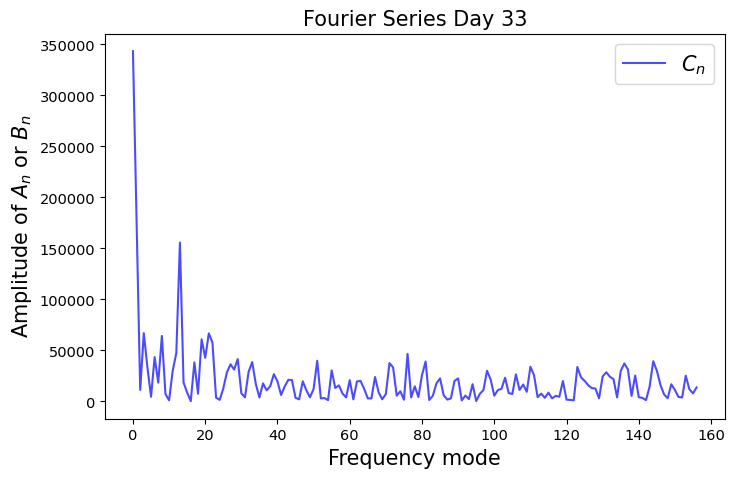

In [15]:
x_val = range(0, len(C_n))

fontsize = 15

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
#plt.plot(x_val, a_n, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
#plt.plot(x_val, b_n, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)
plt.plot(x_val, C_n, label=r'$C_n$', color = "blue", ms = 6, alpha = 0.7)

plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency mode', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Fourier Series Day 33', fontsize=fontsize)
plt.show()

In [16]:
np.argsort(-C_n)

array([  0,   1,  13,   3,  21,   8,  19,  22,  12,  76,   6,  20,  29,
        51, 144,  81,  33,  17,  71, 136,  27, 110, 123,   4,  72, 137,
        28,  55, 145,  98,  11, 135,  32, 131,  26,  39, 106,  80, 111,
       139, 153, 130, 132,  67, 124, 103,  90,  85, 133,  99,  43,  44,
        60,  89, 125,  63, 119,  47,  62,  40,  14,   7,  84,  36,  34,
        94, 149, 108, 146, 126,  57,  38,  78,  42, 143, 156,  56, 127,
        25, 128, 102,  50,  64, 154,   2, 107, 150, 101,  97,  37,  48,
        74, 109,  68,  15, 115, 104,  30, 155,  58, 113,  18,  96,  70,
       105,   9, 147,  41,  86,  92,  73, 100,  83, 117, 138,   5, 118,
       151,  79, 112, 140,  49,  31,  59,  77, 134, 152,  35,  23,  45,
       114, 141,  53, 148, 129, 116,  88,  65,  52,  66,  93,  69,  46,
        61,  87, 120,  75,  24, 121,  82,  54, 142, 122,  10,  91,  95,
        16])

In [19]:
#total number of minutes of sampling for day 33
mins_in_day33 = max(day33['tot_min_rounded']) - min(day33['tot_min_rounded'])
mins_in_day33

317.0

In [21]:
# frequencies with highest vals of coeffs in minutes
mins_in_day33/13
mins_in_day33/3

105.66666666666667

From this we can see that we have a daily trend, a 1/13th day trend, a 1/3 day trend and a 1/21 day trend. Where "day" is the entire study period for which I have data on day 33, ie 317 minutes. 

### Reconstruct the signal from the frequencies

## Code for NO2 data

In [39]:
c = min_avg_NO2['NO2'] #set the signal "strengths" to the observed outcome
c_complex = np.array([complex(num, 0) for num in c])



#need to normalize x to fall within [-3 pi , 3pi]
x = min_avg_NO2 ['tot_min_rounded'] #location of observations
x_norm = 1 * np.pi * (x - np.min(x))/(np.max(x) - np.min(x))

N = len(min_avg_NO2 ['NO2']//2) #number of desired Fourier modes
print(x_norm)

0       0.000000
1       0.000011
2       0.000034
3       0.000045
4       0.000056
          ...   
5144    3.141547
5145    3.141559
5146    3.141570
5147    3.141581
5148    3.141593
Name: tot_min_rounded, Length: 5149, dtype: float64


In [40]:
x_norm = np.ascontiguousarray(x_norm)
c_complex = np.ascontiguousarray(c_complex)

# calculate the type-1 NUFFT
f = finufft.nufft1d1(x_norm, c_complex, N)

In [41]:
# coefficients

k_neg = np.flip(f[0: len(f)//2])
k_pos = f[len(f)//2 + 1:]
print(len(f),len(k_neg), len(k_pos))

C_n = np.abs(k_neg)**2 + np.abs(k_pos)**2
print(C_n)


5149 2574 2574
[2.93564682e+09 2.74521815e+09 2.98817169e+09 ... 4.32421806e+06
 1.17794019e+07 4.55511091e+06]


Plot fourier coefficient

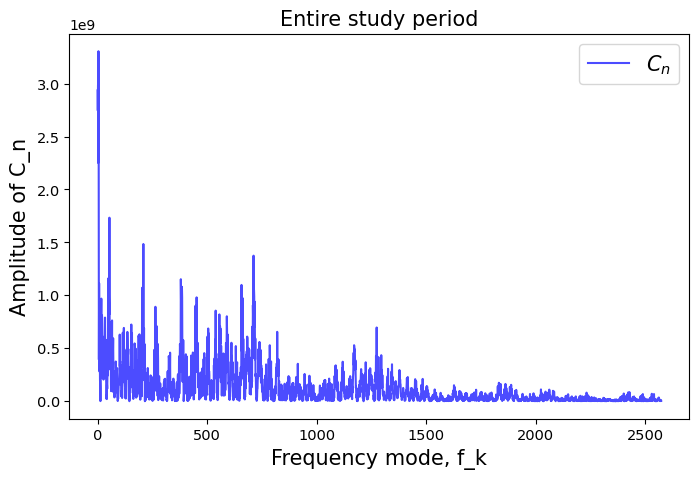

In [42]:
x_val = range(0, len(C_n))

fontsize = 15

plt.figure(figsize=(8,5), dpi=100)
colors = ['black','grey']
#plt.plot(x_val, a_n, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
#plt.plot(x_val, b_n, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)
plt.plot(x_val, C_n, label=r'$C_n$', color = "blue", ms = 6, alpha = 0.7)

plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of C_n', fontsize=fontsize)
plt.xlabel('Frequency mode, f_k', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Entire study period', fontsize=fontsize)
plt.show()

In [43]:
np.argsort(-C_n)[0:50]

array([  4,   2,   0,   1,   5,   3,  54, 209, 712,  49,  51, 380,   7,
       657, 385, 204, 714, 715, 452, 386, 662,  17, 381, 717,  52,  48,
       709, 447, 264, 539, 203, 556,  53,  20, 453, 590, 663,  34,  21,
       710,   8,  55, 711,  66,  57, 206, 154, 270, 559, 707])

In [49]:
total_mins/712 * 1/60 
total_mins/60 * 1/24 * 1/30

6.439259259259259

In [ ]:
#####FIX: WORKING HERE
# need to reverse the normalization to find the correct periodicity I think

Based on this, it looks like there is periodicity at 1/2 the sample period, ~1/104 or 1/101 the study period, ~1/24 or 1/25 the study period, 1/3 the study period

In [29]:
total_mins = max(min_avg_NO2['tot_min_rounded']) - min(min_avg_NO2['tot_min_rounded'])
total_mins

278176.0

In [38]:
print("So the periodicity corresponds to: 1/2 - ", total_mins/2 *1/60 * 1/24, "days", "\n", "1/104 - ", total_mins/104 *1/60, ", ", total_mins/101 * 1/60, "hours",
     "\n", "1/24 or 1/25 - ", total_mins/24 * 1/60 * 1/24, ",", total_mins/25 * 1/60 * 1/24, "days",
     "\n", "1/3 - ", total_mins/3 * 1/60 * 1/24, "days", "\n",
     "1/357 - ", total_mins/357 * 1/60, "hours" )

So the periodicity corresponds to: 1/2 -  96.58888888888889 days 
 1/104 -  44.57948717948718 ,  45.90363036303631 hours 
 1/24 or 1/25 -  8.049074074074074 , 7.727111111111111 days 
 1/3 -  64.39259259259259 days 
 1/357 -  12.986741363211951 hours


## Fitting the Kernel

### Processing the data

In [43]:
df_NO2_train = pd.read_csv("observation_set.csv")
df_NO2_val = pd.read_csv("validation_set.csv")

In [44]:
NO2_mean = df_NO2_train['NO2'].mean()
NO2_std = df_NO2_train['NO2'].std()
print('The mean of NO2 of the training data is', NO2_mean)
print('The standard deviation of NO2 of the training data is', NO2_std)
print('NO2 greater than ', NO2_mean+3*NO2_std, 'is considered outliers')
std_3 = NO2_mean+3*NO2_std

The mean of NO2 of the training data is 12.184664274883055
The standard deviation of NO2 of the training data is 9.761317771145423
NO2 greater than  41.468617588319326 is considered outliers


In [45]:
df_NO2_train_filtered = df_NO2_train[df_NO2_train['NO2']<=std_3]
df_NO2_val_filtered = df_NO2_val[df_NO2_val['NO2']<=std_3]

In [47]:
df_NO2_train_filtered.to_csv('observation_filtered.csv', index=False)
df_NO2_val_filtered.to_csv('validation_filtered.csv', index=False)

In [49]:
df_NO2_train_filtered = pd.read_csv('observation_filtered.csv')
max(df_NO2_train_filtered['NO2'])

41.3711

In [ ]:
train_avg_NO2 = df_NO2_train.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()
val_avg_NO2 = df_NO2_val.groupby('tot_min_rounded').agg({'datetime': 'first', 'NO2': 'mean'}).reset_index()
train_avg_NO2

Text(0, 0.5, 'NO2')

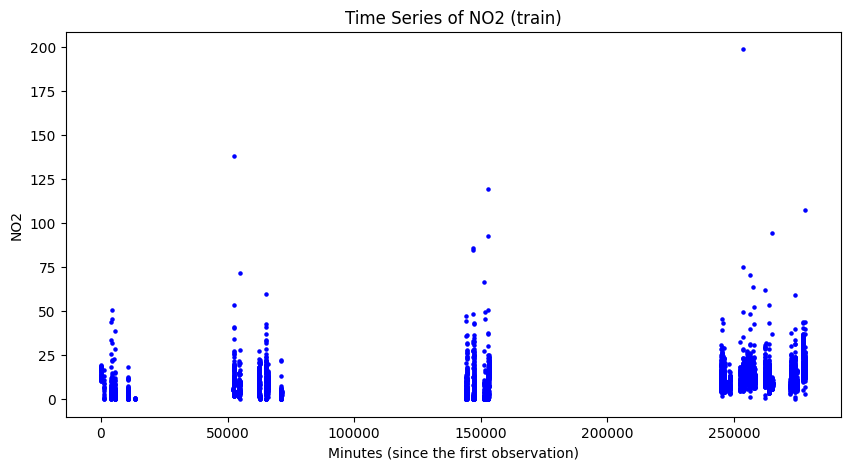

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(train_avg_NO2['tot_min_rounded'], train_avg_NO2['NO2'], color='blue', s=5)
plt.title('Time Series of NO2 (train)')
plt.xlabel('Minutes (since the first observation)')
plt.ylabel('NO2')

Text(0, 0.5, 'NO2')

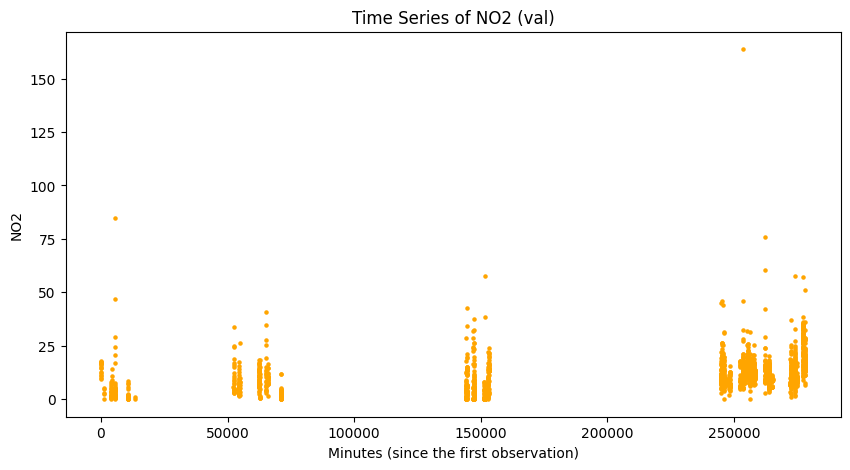

In [21]:
plt.figure(figsize=(10, 5))
plt.scatter(val_avg_NO2['tot_min_rounded'], val_avg_NO2['NO2'], color='orange', s=5)
plt.title('Time Series of NO2 (val)')
plt.xlabel('Minutes (since the first observation)')
plt.ylabel('NO2')

#### fitting the kernel for period = 6.5hrs

In [ ]:
gp = GaussianProcessRegressor(kernel=RBF(length_scale=0.5, length_scale_bounds="fixed"), random_state=42)
gp.fit(X_train, y_train)
y_train_pred, sigma = gp.predict(X_train, return_std=True)
mse = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error (training):", mse)